In [3]:
from __future__ import division, absolute_import

import numpy as np

from bcn.bias import guess_func
from bcn.data import DataSimulated, estimate_partial_signal_characterists
from bcn.cost import Cost
from bcn.solvers import ConjugateGradientSolver
from bcn.linear_operators import LinearOperatorCustom, LinearOperatorEntry, possible_measurements

import pylab as pl
import seaborn as sb

In [4]:
np.random.seed(seed=42)
sb.set(font_scale=0.7)

## Case study

### Story

You have to work with two datasets that are corrupted by an unknown number of confounding factors. Both datasets consist of a matrix of samples and features. For example, customers and products with a rating of satisfaction, location and time of temperature measurements accross the globe, or the change in value of stocks at closing time at the financial markets. Thus, values in the matrix are continuous and can range from negative to positive.

Luckily, for dataset **A** you were able to determine the true values for a small subset of matrix entries, for example through quantitative measurement standards or time intensive in-depth analysis. Thus, the recovery of confounding factors is now similar to a matrix recovery problem through entry sensing, as the observed values subtracted by the true values give the necessary entries for the bias matrix of confounding factors to be recovered. 

For dataset **B** it is more challenging, as you were not able to determine any entries. However, instead you know with certainty that several of the samples and several of the features are strongly correlated and that you are likely to be able to identify those, as the corruption through the confounding factors is not stronger than the underlying signal. Thus the problem can be approached by blind normalization.

In order to remove the unknown confounding factors several assumptions have to be satisfied for dataset **A** and **B**. First of all, the to be recovered bias matrix must lie on a sufficiently low dimensional manifold, such as a low rank matrix. Secondly, it must satisfy certain incoherence requirements. If both assumptions are satisfied, the otherwise NP-HARD matrix recovery problem can be solved efficiently in the framework of compressed sensing. 

### Outline
1. Definition of additional functions
2. Creation of the two datasets
3. Normalization of dataset **A**    
4. Normalization of dataset **B**
5. Conclusion

### 1. Definition of additional functions

In [5]:
def indices_shuffled(shape):
    indices_x = np.arange(shape[0], dtype=int)
    indices_y = np.arange(shape[1], dtype=int)
    np.random.shuffle(indices_x)
    np.random.shuffle(indices_y)
    return indices_x, indices_y

In [6]:
def show_absolute(signal, kind, shuffle=False):
    indices_x = np.arange(signal.shape[0], dtype=int)
    indices_y = np.arange(signal.shape[1], dtype=int)
    fig = pl.figure(figsize=(6 * (signal.shape[1] / signal.shape[0]), 6))
    ax = fig.add_subplot(111)
    ax.set_title('{}'.format(kind))
    if shuffle:
        np.random.shuffle(indices_x)
        np.random.shuffle(indices_y)
        ax.set_title('{} (shuffled)'.format(kind))
    ax_seaborn = sb.heatmap(signal[indices_x[:, None], indices_y], vmin=-4, vmax=4, cmap=pl.cm.seismic, ax=ax, cbar_kws={'shrink': 0.5}, xticklabels=indices_y, yticklabels=indices_x)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xlabel('Features')
    ax.set_ylabel('Samples')

In [7]:
def show_dependences(signal, pairs, space, n_pairs=5, n_points=50):
    if space == 'feature':
        shape = signal.T.shape
    if space == 'sample':
        shape = signal.shape
    pairs = pairs[space]
    for n, i in enumerate(np.random.choice(np.arange(len(pairs), dtype=int), min(n_pairs, len(pairs)), replace=False)):
        j = np.random.choice(np.arange(shape[1], dtype=int), min(n_points, shape[1]), replace=False)
        if space == 'sample':
            grid = sb.jointplot(signal[np.atleast_2d(pairs[i][1]), j], signal[np.atleast_2d(pairs[i][0]), j], ylim=(-4, 4), xlim=(-4, 4), alpha=0.6, stat_func=None, color='black')
            grid.set_axis_labels('Sample {}'.format(pairs[i][1]), 'Sample {}'.format(pairs[i][0]))
        if space == 'feature':
            grid = sb.jointplot(signal[j[:, None], pairs[i][1]], signal[j[:, None], pairs[i][0]], ylim=(-4, 4), xlim=(-4, 4), alpha=0.6, stat_func=None, color='black')
            grid.set_axis_labels('Feature {}'.format(pairs[i][1]), 'Feature {}'.format(pairs[i][0]))
     

In [8]:
def show_independences(signal, pairs, space, n_pairs=5, n_points=50):
    if space == 'feature':
        shape = signal.T.shape
    if space == 'sample':
        shape = signal.shape
    true_pairs = set()
    for pair in pairs[space]:
        true_pairs.add((pair[0], pair[1]))
        true_pairs.add((pair[1], pair[0]))
    all_pairs = set()
    for i in xrange(shape[0]):
        for j in range(shape[0]):
            all_pairs.add((i, j))
            all_pairs.add((j, i))
    non_pairs = all_pairs - true_pairs
    pairs = {space: np.asarray(list(non_pairs), dtype=int)}
    show_dependences(signal, pairs, space, n_pairs=n_pairs, n_points=n_points)

### 2. Creation of the two datasets

In [25]:
# Setup of general parameters for the recovery experiment.
n_restarts = 10
rank = 6
n_measurements = 2800
shape = (50, 60) # samples, features
missing_fraction = 0.1
noise_amplitude = 4.0
m_blocks_size = 5 # size of each block
correlation_threshold = 0.9
bias_model = 'image'

In [10]:
# Number of possible measurements (more equals better signal recovery) 
possible_measurements(shape, missing_fraction, m_blocks_size=m_blocks_size)

{'m_blocks=10/12 (actual case)': 'TODO',
 'm_blocks=2/2 (worst case)': 71550,
 'm_blocks=25/30 (best case)': 2700}

In [11]:
# Creation of the true signal and corrupted signal.
truth = DataSimulated(shape, rank, bias_model=bias_model, correlation_threshold=correlation_threshold, m_blocks_size=m_blocks_size, noise_amplitude=noise_amplitude, missing_fraction=missing_fraction)

/home/sohse/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
true_bias = truth.d['sample']['true_bias']
true_signal = truth.d['sample']['signal']
true_pairs = {'sample': truth.d['sample']['true_pairs'], 'feature': truth.d['feature']['true_pairs']}
true_directions = {'sample': truth.d['sample']['true_directions'], 'feature': truth.d['feature']['true_directions']}
true_stds = {'sample': truth.d['sample']['true_stds'], 'feature': truth.d['feature']['true_stds']}

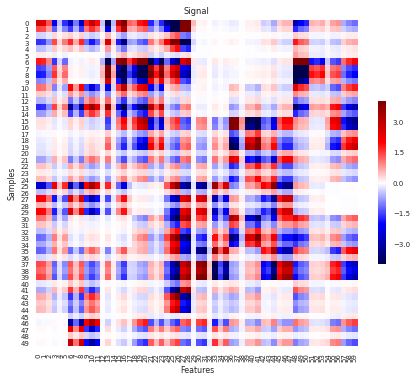

In [13]:
show_absolute(true_signal, kind='Signal')

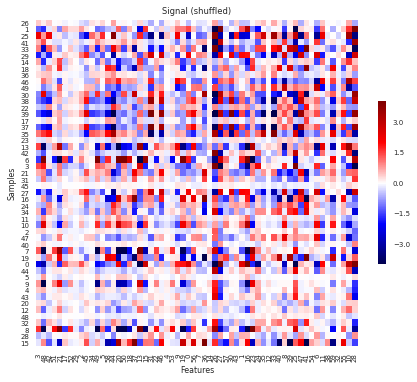

In [14]:
show_absolute(true_signal, kind='Signal', shuffle=True)

/home/sohse/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


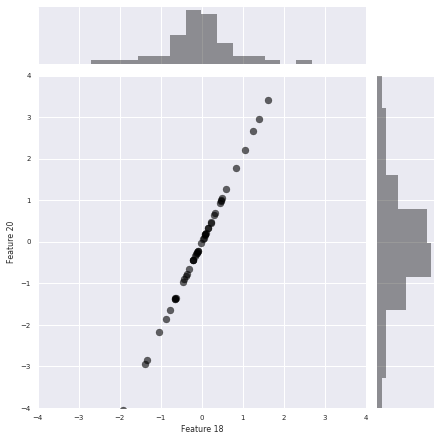

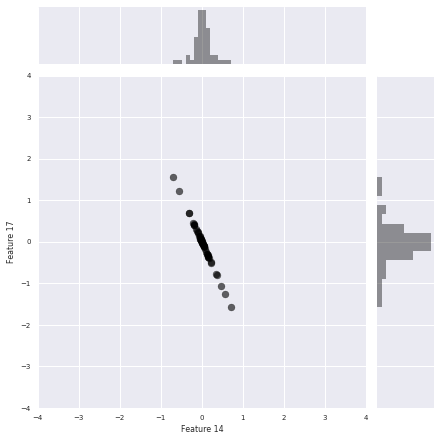

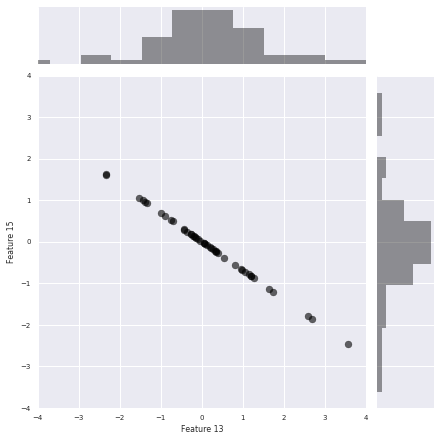

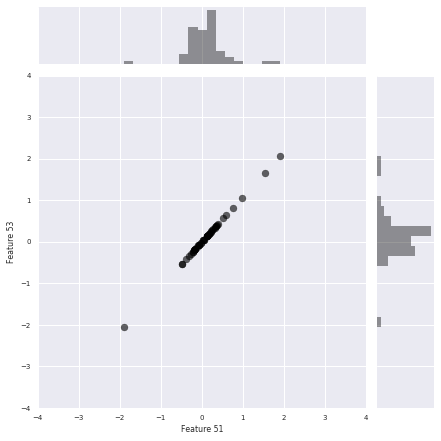

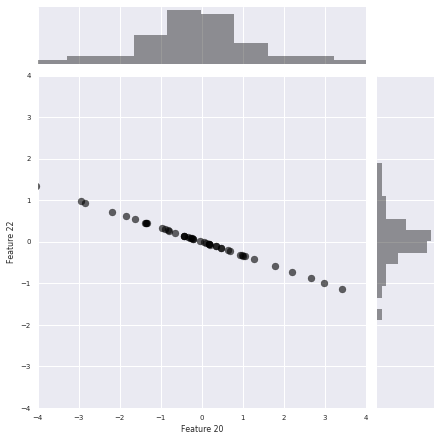

In [15]:
show_dependences(true_signal, true_pairs, 'feature')

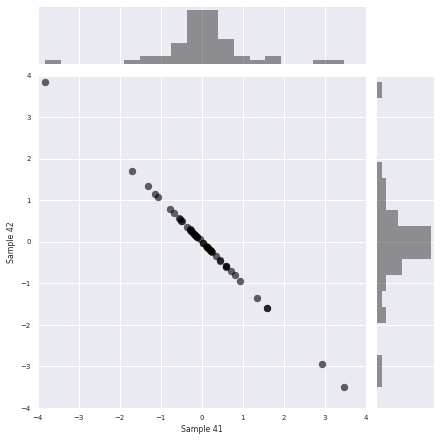

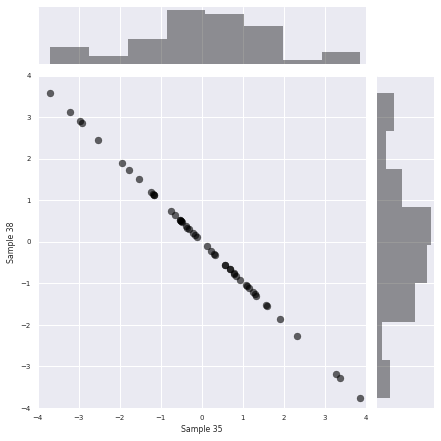

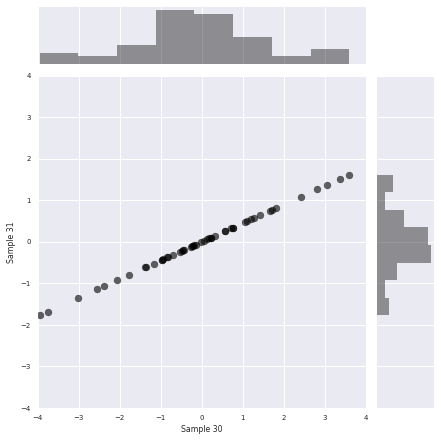

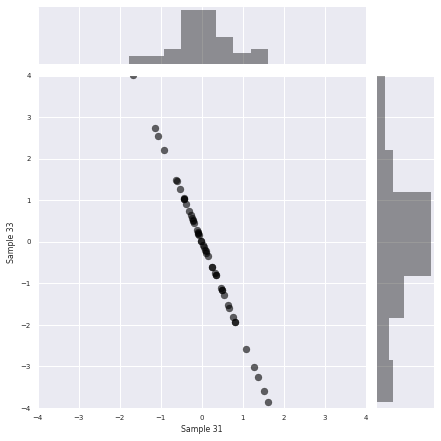

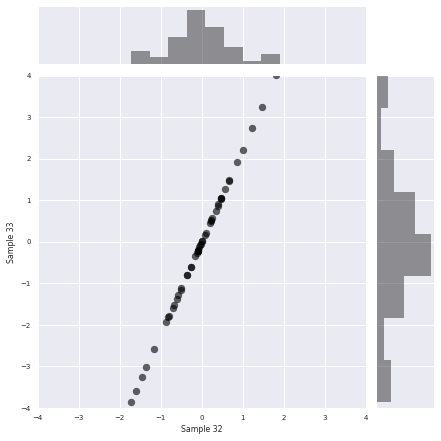

In [16]:
show_dependences(true_signal, true_pairs, 'sample')

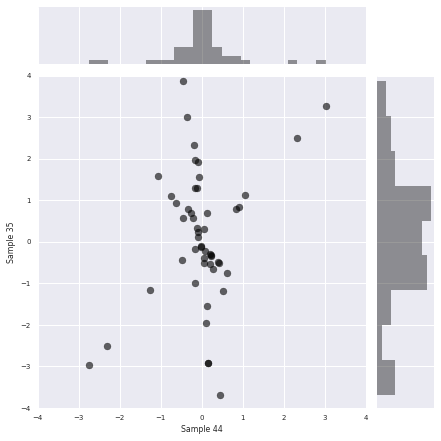

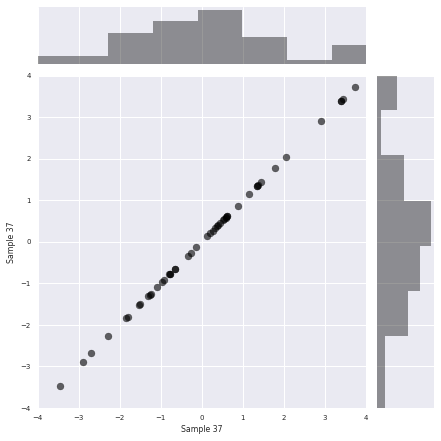

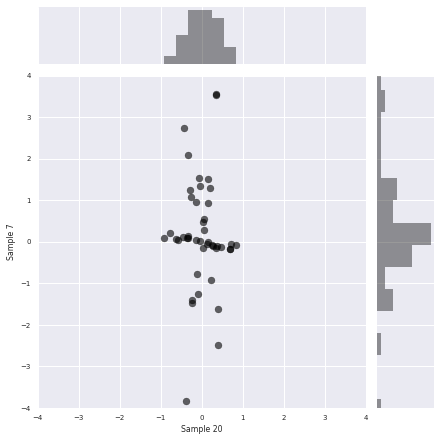

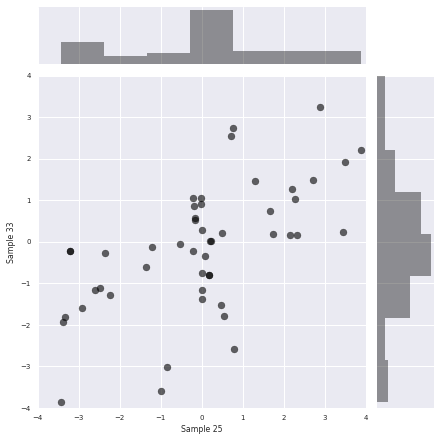

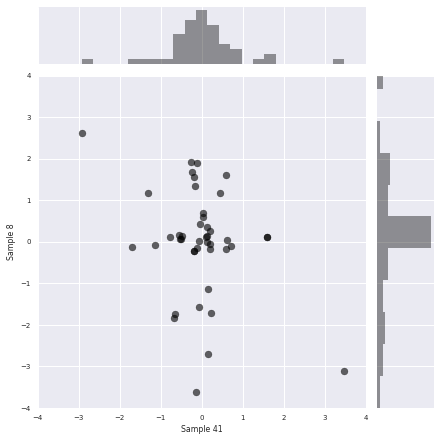

In [17]:
show_independences(true_signal, true_pairs, 'sample')

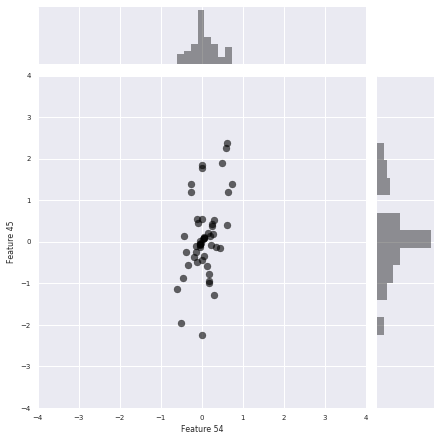

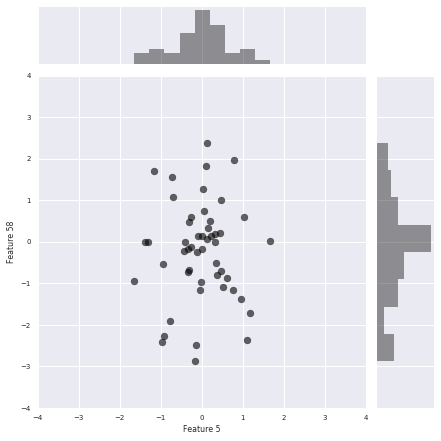

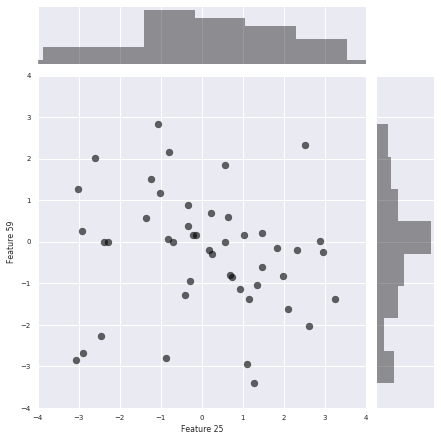

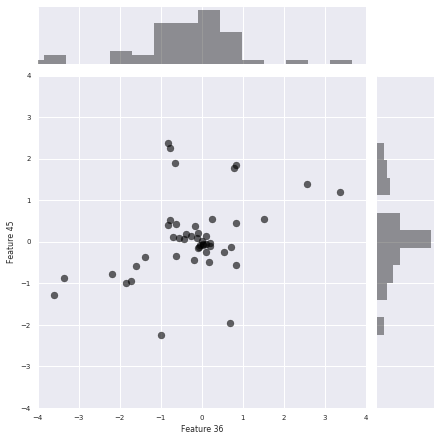

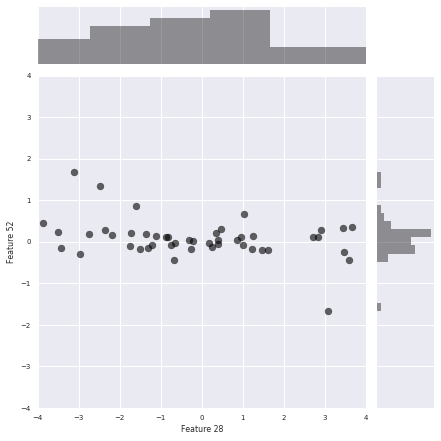

In [18]:
show_independences(true_signal, true_pairs, 'feature')

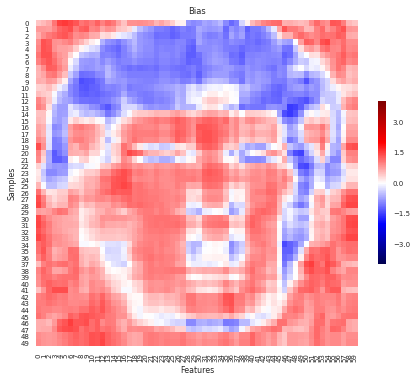

In [19]:
show_absolute(true_bias, kind='Bias')

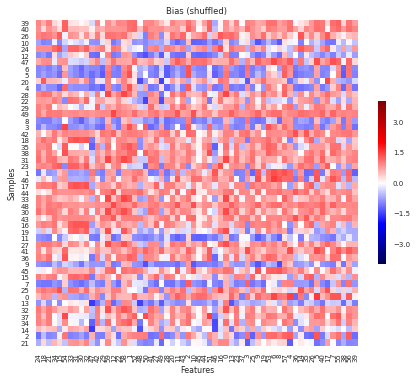

In [20]:
show_absolute(true_bias, kind='Bias', shuffle=True)

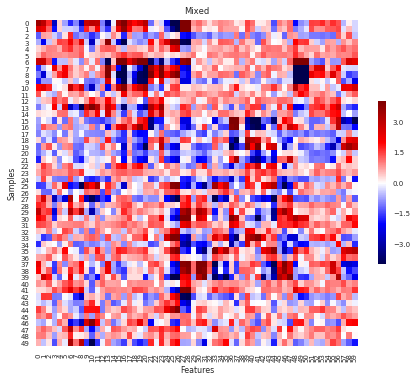

In [21]:
indices = indices_shuffled(true_bias.shape)
mixed = true_signal + true_bias[indices[0][:, None], indices[1]]
show_absolute(mixed, kind='Mixed')

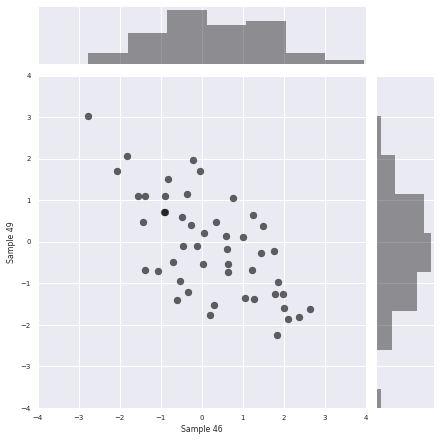

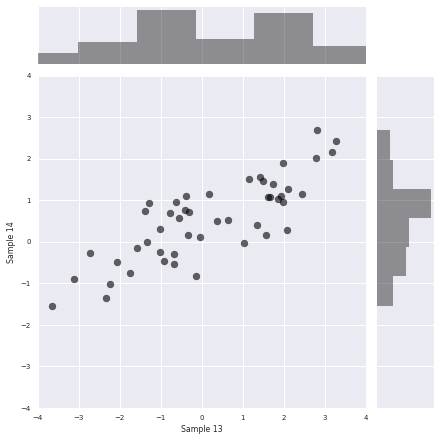

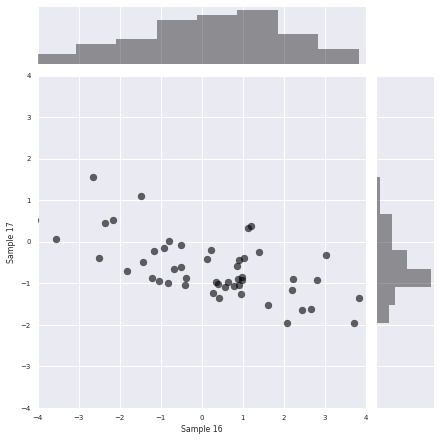

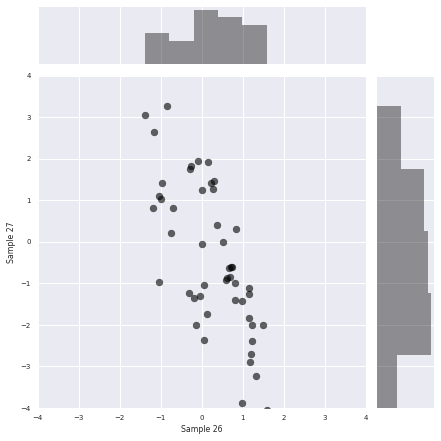

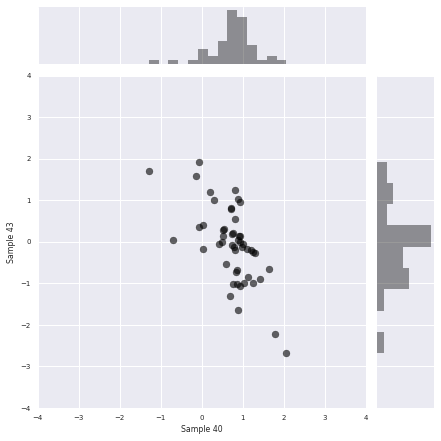

In [22]:
show_dependences(mixed, true_pairs, 'sample')

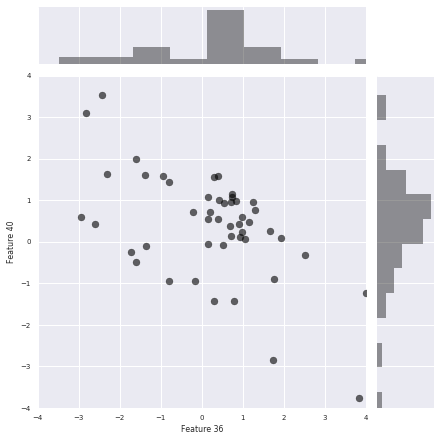

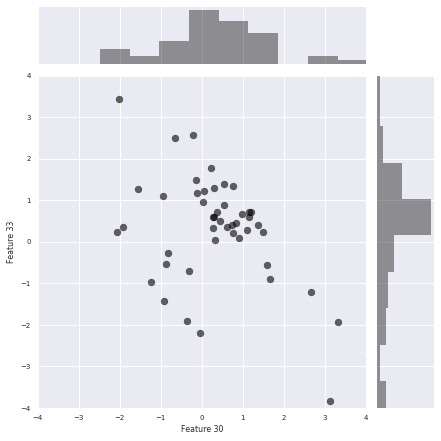

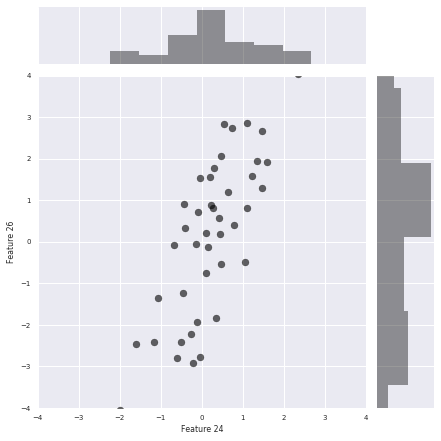

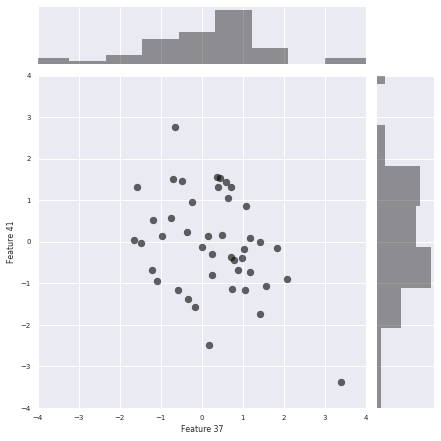

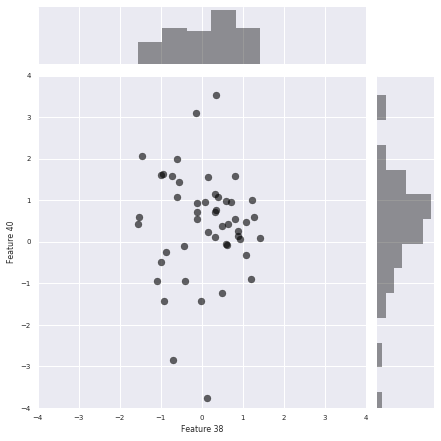

In [23]:
show_dependences(mixed, true_pairs, 'feature')

### 3. Normalization of dataset **A**

In [29]:
# Construct measurements from known entries.
operator = LinearOperatorEntry(n_measurements)
measurements = operator.generate(true_bias)

In [35]:
# Construct cost function.
sparsity = 1
cost = Cost(measurements['A'], measurements['y'], sparsity)

In [36]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, n_restarts, verbosity=0)
results = solver.recover()

In [37]:
# Recovery performance statistics.
error_cost_func_true_bias = cost.cost_func(truth.d['sample']['true_bias'])
error_cost_func_estimated_bias = cost.cost_func(results['estimated_bias'])
print 'error_cost_func_true_bias', error_cost_func_true_bias
print 'error_cost_func_estimated_bias', error_cost_func_estimated_bias

divisor = np.sum(~np.isnan(mixed))
print 'number of valid values', divisor

mean_absolute_error_true_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - (mixed - truth.d['sample']['true_bias']))) / divisor
mean_absolute_error_estimated_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - results['estimated_signal'])) / divisor
print 'mean_absolute_error_true_signal', mean_absolute_error_true_signal
print 'mean_absolute_error_estimated_signal', mean_absolute_error_estimated_signal

mean_absolute_error_zeros = np.nansum(np.absolute(truth.d['sample']['signal'] - mixed)) / divisor
print 'mean_absolute_error_zeros', mean_absolute_error_zeros

ratio_estimated_signal_to_zeros = mean_absolute_error_estimated_signal / mean_absolute_error_zeros
print 'ratio_estimated_signal_to_zeros', ratio_estimated_signal_to_zeros

error_cost_func_true_bias 0.0
error_cost_func_estimated_bias 1.1015256924487727e-22
number of valid values 3000
mean_absolute_error_true_signal 0.8831987983774634
mean_absolute_error_estimated_signal 0.8831987983765449
mean_absolute_error_zeros 0.748440859394239
ratio_estimated_signal_to_zeros 1.1800515528927351


### 4. Normalization of dataset **B**

In [367]:
signal_characterists = estimate_partial_signal_characterists(mixed, correlation_threshold, true_pairs=true_pairs, true_directions=true_directions, true_stds=true_stds)

In [368]:
# Construct measurements from corrupted signal and its estimated partial characteristics.
operator = LinearOperatorCustom(n_measurements)
measurements = operator.generate(signal_characterists)

In [369]:
# Construct cost function.
sparsity = 2
cost = Cost(measurements['A'], measurements['y'], sparsity)

In [370]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, n_restarts, verbosity=0)
results = solver.recover()

In [371]:
# Recovery performance statistics.
error_cost_func_true_bias = cost.cost_func(truth.d['sample']['true_bias'])
error_cost_func_estimated_bias = cost.cost_func(results['estimated_bias'])
print 'error_cost_func_true_bias', error_cost_func_true_bias
print 'error_cost_func_estimated_bias', error_cost_func_estimated_bias

divisor = np.sum(~np.isnan(mixed))
print 'number of valid values', divisor

mean_absolute_error_true_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - (mixed - truth.d['sample']['true_bias']))) / divisor
mean_absolute_error_estimated_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - results['estimated_signal'])) / divisor
print 'mean_absolute_error_true_signal', mean_absolute_error_true_signal
print 'mean_absolute_error_estimated_signal', mean_absolute_error_estimated_signal

mean_absolute_error_zeros = np.nansum(np.absolute(truth.d['sample']['signal'] - mixed)) / divisor
print 'mean_absolute_error_zeros', mean_absolute_error_zeros

ratio_estimated_signal_to_zeros = mean_absolute_error_estimated_signal / mean_absolute_error_zeros
print 'ratio_estimated_signal_to_zeros', ratio_estimated_signal_to_zeros
    

error_cost_func_true_bias 3.071963874639757
error_cost_func_estimated_bias 1.9669931695673412e-15
number of valid values 3000
mean_absolute_error_true_signal 0.8236553166674749
mean_absolute_error_estimated_signal 1.90882446713806e-08
mean_absolute_error_zeros 0.748440859394239
ratio_estimated_signal_to_zeros 2.5504012016166426e-08


### 4. Conclusion